In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [4]:
class fucking_Neural_network(object):
    ''' Defining the neural network class'''
    def __init__(self):
        # Parameters that do not change (hyperparameters)
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        # Initializing weights
        self.w1 = np.random.randn(self.inputLayerSize, self.hiddenLayerSize)
        self.w2 = np.random.randn(self.hiddenLayerSize, self.outputLayerSize)
        print(self.w1.shape,self.w2.shape)
        
    def forward(self,x):
        # Forward propagation
        self.z2 = np.dot(x, self.w1) # inputs x synapse weights 1
        self.a2 = fucking_sigmoid(np.array(self.z2)) # apply activation function
        self.z3 = np.dot(self.a2, self.w2) # output of layer x synapse weights 2
        y_hat = fucking_sigmoid(self.z3) # apply activation function again
        return y_hat

NN = fucking_Neural_network()

(2, 3) (3, 1)


In [5]:
def fucking_sigmoid(z):
    # Applying a sigmoidal activation function
    return 1/(1 + np.exp(-z))

def sigmoidPrime(z):
    # Derivative of above sigmoid function
    return np.exp(-z)/((1 + np.exp(-z))**2)

In [37]:
def costFunction(X,y):
    # Using the sum of the squared error as cost
    NN.y_hat = NN.forward(X)
    cost = 0.5*sum((y-NN.y_hat)**2)/X.shape[0] + (Lambda/2)*(np.sum(NN.w1**2) + sum(NN.w2**2))  
    return cost

def costFunctionPrime(X, y):
    # Derivative with respect to w1 and w2
    NN.y_hat = NN.forward(X)
    
    delta3 = np.multiply(-(y - NN.y_hat), sigmoidPrime(NN.z3))
    #print(delta3.shape, NN.w2.shape)
    dJdw2 = np.dot(NN.a2.T, delta3) + Lambda*NN.w2
    delta2 = np.multiply(delta3, NN.w2.T) * (sigmoidPrime(NN.z2))
    #print(delta2.shape)
    dJdw1 = np.dot(X.T, delta2) + Lambda*NN.w1
    print(delta3.shape, y.shape, sigmoidPrime(NN.z3).shape)
    
    return dJdw1, dJdw2

In [38]:
def getParams():
    # Get w1 and w2 as vectors
    params = np.concatenate((NN.w1.ravel(), NN.w2.ravel()))
    return params

def setParams(params):
    # Take w as vectors and set new w1 and w2
    w1_start = 0
    w1_end = NN.hiddenLayerSize * NN.inputLayerSize
    NN.w1 = np.reshape(params[w1_start:w1_end], (NN.inputLayerSize, NN.hiddenLayerSize))
    w2_end = w1_end + NN.hiddenLayerSize*NN.outputLayerSize
    NN.w2 = np.reshape(params[w1_end:w2_end], (NN.hiddenLayerSize, NN.outputLayerSize))

def computeGradient(X,y):
    # Computes a gradient (duh)
    dJdw1, dJdw2 = costFunctionPrime(X,y)
    return np.concatenate((dJdw1.ravel(), dJdw2.ravel()))
    

In [39]:
''' Sample execution with test values '''
X = np.array(([3,5],[5,1],[10,2], [6,1.5]), dtype=float)
y = np.array(([75],[82],[93],[70]), dtype = float)
X = X/np.amax(X, axis=0)
y = y/100

# Regularization parameter
Lambda = 0.0003

testRun = NN.forward(X)

In [40]:
testRun

array([[ 0.75492421],
       [ 0.80052704],
       [ 0.8353906 ],
       [ 0.80674411]])

In [41]:
cost1 = costFunction(X,y)
dJdw1, dJdw2 = costFunctionPrime(X,y)

# When we account for derivatives (by subtracting them) 
# the cost should go down
NN.w1 = NN.w1 - 3*dJdw1
NN.w2 = NN.w2 - 3*dJdw2
cost3 = costFunction(X,y)

print (cost1, cost3)

(4, 1) (4, 1) (4, 1)
[ 0.00346497] [ 0.0034652]


In [42]:
def computeNumericalGradient(N,X,y):
    ''' Estimating the gradient numerically to compare values. '''
    paramsInitial = getParams()
    numgrad = np.zeros(paramsInitial.shape)
    perturb = np.zeros(paramsInitial.shape)
    e = 1e-4
    
    for p in range(len(paramsInitial)):
        # Set perturbation vector
        perturb[p] = e
        setParams(paramsInitial + perturb)
        loss2 = costFunction(X,y)
        
        setParams(paramsInitial - perturb)
        loss1 = costFunction(X,y)
        
        # Compute num grad
        numgrad[p] = (loss2 - loss1)/(2*e)
        
        #Return changed value to zero
        perturb[p] = 0
    
    # Return params to original values
    setParams(paramsInitial)

    return numgrad 

In [43]:
numgrad = computeNumericalGradient(NN, X, y)
grad = computeGradient(X,y)
print(grad)
# This measures how similar they are (should be < 10^8)
np.linalg.norm(grad-numgrad) / np.linalg.norm(grad+numgrad)

(4, 1) (4, 1) (4, 1)
[ -1.27216986e-04  -1.50938012e-04  -1.23863447e-04   1.12052416e-04
  -8.36924883e-05   1.33161205e-04   8.47567878e-05  -1.99945505e-04
   4.30259834e-05]


1.4342301412560758

In [31]:
class trainer(object):
    ''' Defining a training class. Modified to check testing error during training. '''
    def __init__(self, N):
        # Make a local reference to the neural network
        self.N = N    
        
    def callbackF(self, params):
        setParams(params)
        self.J.append(costFunction(self.X, self.y))
        self.testJ.append(costFunction(self.testX, self.testy))
    
    def costFunctionWrapper(self, params, X, y):
        # To track the cost function over training time
        setParams(params)
        cost = costFunction(X, y)
        grad = computeGradient(X, y)
        print(cost.shape, "Grad:", grad.shape)
        return cost, grad
    
    # This is the actual train function
    def train(self, trainX, trainy, testX, testy):
        # Make internal variable for callback
        self.X = trainX
        self.y = trainy
        
        self.testX = testX
        self.testy = testy
        
        # Make empty list to store costs
        self.J = []
        self.testJ = []
        params0 = getParams()
        print(params0.shape)
        
        options = {'maxiter': 200, 'disp': True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac = True, method = 'BFGS', args = (X,y), options = options, callback = self.callbackF)
        
        # Update params with new values from last iteration
        setParams(_res.x)
        self.optimizationResults = _res

In [32]:
''' Sample execution with Training and Testing values '''
trainX = np.array(([3,5],[5,1],[10,2], [6,1.5]), dtype=float)
trainy = np.array(([75],[82],[93],[70]), dtype = float)
trainX = trainX/np.amax(trainX, axis=0)
trainy = trainy/100.

testX = np.array(([4,5.5],[4.5,1],[9,2.5], [6,2]), dtype=float)
testy = np.array(([70],[89],[85],[75]), dtype = float)

testX = testX/np.amax(testX, axis=0)
testy = testy/100

In [33]:
T = trainer(NN)
T.train(trainX, trainy, testX, testy)

(9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,) Grad: (9,)
(1,

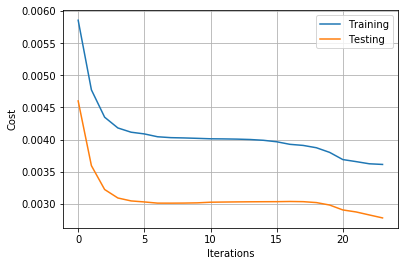

In [16]:
plt.plot(T.J)
plt.plot(T.testJ)
plt.grid(1)
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.legend(['Training', 'Testing'])
plt.show()

In [17]:
costFunctionPrime(X,y)

(4, 1) (3, 1)
(4, 3)


(array([[ 0.00030752,  0.00032638,  0.0003806 ],
        [ 0.00010763, -0.00012196,  0.00011678]]), array([[ 0.00299623],
        [ 0.00291187],
        [ 0.00302503]]))

In [18]:
NN.forward(X)

array([[ 0.74843073],
       [ 0.8157308 ],
       [ 0.84605849],
       [ 0.81933753]])

In [19]:
y

array([[ 0.75],
       [ 0.82],
       [ 0.93],
       [ 0.7 ]])

In [20]:
''' Final test using random data'''

hoursSleep = np.linspace(0,10,100)
hoursStudy = np.linspace(0,5,100)

# Normalize
hoursSleepNorm = hoursSleep/10.
hoursStudyNorm = hoursStudy/5.

# Make into 2D arrays
a, b = np.meshgrid(hoursSleepNorm, hoursStudyNorm)

# Merge into single matrix
allInputs = np.zeros((a.size,2))
allInputs[:,0]: a.ravel()
allInputs[:,1]: b.ravel()

In [21]:
allOutputs = NN.forward(allInputs)